# Inspect GLASS models and generate synthetic images

## Imports

In [1]:
import sys
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
root = "/Users/phdenzel/gleam"
sys.path.append(root)
import gleam
from gleam.lensobject import LensObject
from gleam.utils.lensing import LensModel
from gleam.reconsrc import ReconSrc, run_model
from gleam.utils.plotting import kappa_map_plot, kappa_profiles_plot
from gleam.utils.plotting import arrival_time_surface_plot
from gleam.utils.plotting import plot_scalebar, plot_labelbox
from gleam.utils.rgb_map import radial_mask
import gleam.utils.colors as gcl
gcl.GLEAMcmaps.register_all()


## Load data files

In [2]:
#        ACS          ACS(WFC3)        ACS(WFC3)      WFC3(UNK)
#        ACS(WFC3)    SBC              WFC3           ACS(GAIA)
objs = ['B1608+656', 'DESJ0408-5354', 'HE0435-1223', 'PG1115+080',
        'RXJ0911+0551', 'RXJ1131-1231', 'SDSSJ1004+4112', 'WFIJ2033-4723']
objidx = 3
sigf = 600     #   80,  100,   60,  600,  140, 4000,   80,   80
lens = objs[objidx]
print(lens)


PG1115+080


In [3]:
fitsdir = 'data/delay_qsos/'
fitsfile = fitsdir + '{}.fits'.format(lens)
print(fitsfile)

jsondir = 'jsons/'
jsonfile = jsondir + '{}.json'.format(lens)
print(jsonfile)


data/delay_qsos/PG1115+080.fits
jsons/PG1115+080.json


In [4]:
with open(jsonfile) as f:
    lo = LensObject.from_json(f)
lo.squarify(0)
print(lo.__v__)


Properties of that field are unknown [None]
filename            	PG1115+080.json
filepath            	/Users/phdenzel/delays/jsons/PG1115+080.json
band                	
naxis1              	99
naxis2              	99
naxis_plus          	None
refval              	[169.57094740092, 7.766067434866]
refpx               	[36.0, 41.0]
center              	<169.5705, 7.7664>
px2deg              	[3.562500079472802e-05, 3.5625000794728505e-05]
px2arcsec           	[0.12825000286102087, 0.12825000286102262]
megacam_range       	None
field               	None
photzp              	None
mag_formula         	<function mag_formula at 0x7fd6683e9050>
roi                 	ROISelector(99, 99)
lens                	None
srcimgs             	[]
zl                  	0.5
zs                  	3.0
mapr                	6.3484
tdelay              	None
tderr               	None
light_model         	{}
stel_mass           	None
glscfactory         	GLSCFactory(zl, srcimgs, parity, tderr...)
finder              

In [5]:
statedir = 'states/'
statefiles = ['11doubles_dg45.state',
              '11doubles_dg60.state', '11doubles_CMB_dg60.state', '11doubles_SNeIa_dg60.state',
              '7quads_dg45.state', '7quads_CMB_dg45.state', '7quads_SNeIa_dg45.state',
              '7quads_dg60.state', '7quads_CMB_dg60.state', '7quads_SNeIa_dg60.state', 
              'all_dg60.state', 'all_SNeIa_dg60.state']
statefile = statefiles[7]  # 7  8/9 5/6
print(statefile)


7quads_dg60.state


In [6]:
lm = LensModel(statedir+statefile)
lm.obj_idx = objidx
print(lm.__v__)


filename            	7quads_dg60.state
filepath            	states/7quads_dg60.state
N                   	1000
pixrad              	8
maprad              	1.67273244599
pixel_size          	0.0393584104938
kappa               	None
minima              	[[ 0.11439883300091856  1.3727859960110342 ]
 [-0.7864919768813123  -0.872291101632015  ]]
saddle_points       	[[-1.058189205258495   -0.4289956237534523 ]
 [ 0.8579912475068856  -0.45759533200368047]]
maxima              	[]
zl                  	0.311
zs                  	1.735
N_obj               	8
N_src               	1
obj_idx             	3
src_idx             	0


## Source reconstruction

In [7]:
# lo.data = np.fliplr(lo.data)
reconsrc = ReconSrc(lo, lm, M=80, M_fullres=400, mask_keys=['circle'])
reconsrc.chmdl(-1)
sig2 = sigf * np.abs(reconsrc.lensobject.data)
sig2[sig2 == 0] = sig2[sig2 != 0].min()

print reconsrc.lensobject.data.shape


(99, 99)


In [8]:
# reconsrc.calc_psf("psf/tinytim_ACS.fits", normalize=True, window_size=8, verbose=True)
# reconsrc.calc_psf("psf/tinytim_SBC.fits", normalize=True, window_size=8, verbose=True)
reconsrc.calc_psf("psf/tinytim_WFC3.fits", normalize=True, window_size=8, verbose=True)
# reconsrc.calc_psf("psf/tinytim_WFC3.fits", normalize=True, window_size=4, verbose=True)


PSF: P_kl(9801, 9801)
Sum: 0.995367273448


<9801x9801 sparse matrix of type '<type 'numpy.float64'>'
	with 2595321 stored elements in Compressed Sparse Row format>

In [9]:
# reconsrc.rotation = -98.2


In [10]:
kw = dict(method='minres', use_psf=True, use_mask=True, use_filter=False, sigma2=sig2.copy(),
          cached=True, from_cache=False, save_to_cache=False)
          # cached=True, from_cache=True, save_to_cache=True)


In [11]:
%%script false
dbeta, xy, r_max, r_fullres = reconsrc.inv_proj_matrix(use_mask=True, return_props=True)
plt.hist2d(xy[:, 0], xy[:, 1])
plt.show()


In [12]:
%%script false
from __future__ import print_function
qs = []
for i in range(-1, reconsrc.model.N):
    reconsrc.chmdl(i)
    reconsrc.inv_proj_matrix(use_mask=True, r_max=2)
    chi2 = reconsrc.reproj_chi2(reduced=False, **kw)
    qs.append(chi2)
    message = "{:8.4f} @ {:04d}".format(chi2, i)
    print(message, end="\r")


In [13]:
%%script false
np.savetxt("{}_{}_chi2.txt".format(lm.filename.replace('.state', ''), lens), qs)

In [14]:
%%script false
#qs = np.loadtxt("results/7quads_CMB_dg60_B1608+656_chi2.txt")
qs = np.loadtxt("results/7quads_SNeIa_dg60_DESJ0408-5354_chi2.txt")

In [15]:
# %%script false
reconsrc.chmdl(-1)

Mij = reconsrc.inv_proj_matrix(use_mask=True)
# Mij = reconsrc.inv_proj_matrix(use_mask=True, r_max=2)
# Mij = reconsrc.inv_proj_matrix(use_mask=False, r_max=10)

In [16]:
dij = reconsrc.lens_map(mask=True)
print("Calculating source plane...")
srcplane = reconsrc.d_p(method=kw['method'], flat=False, iter_lim=10000,
                        use_psf=kw['use_psf'], use_mask=kw['use_mask'], use_filter=kw['use_filter'],
                        sigma2=kw['sigma2'], cached=kw['cached'])
print("Calculating synthetic...")
synth = reconsrc.reproj_map(**kw)
# print("Calculating residuals...")
# resids = reconsrc.residual_map(**kw)
# print("Calculating chi2...")
# chi2 = reconsrc.reproj_chi2(reduced=False, **kw)
print(reconsrc.__v__)


Calculating source plane...
Calculating synthetic...
lensobject          	LensObject(@[169.5705, 7.7664])
model               	<LensModel@7quads_dg60>
mask_keys           	['circle']
M                   	80
N                   	161
r_max               	0.836366222994
M_fullres           	883
N_fullres           	1767
r_fullres           	9.23313582163
N_nil               	9106
rotation            	0


In [17]:
print("dij:      \t{}".format(dij.shape))
print("Mij:      \t{}".format(Mij.shape))
print("dp:       \t{}".format(srcplane.shape))
# print "chi2:     \t{:6.4f}".format(chi2)
print("r_max:    \t{:6.4f}".format(reconsrc.r_max))
print("r_fullres \t{:6.4f}".format(reconsrc.r_fullres))
print("src pxl:  \t{:6.4f}".format(reconsrc.src_pxscale))
print("maprad    \t{:6.4f}".format(reconsrc.lensobject.mapr))
print("lens pxl: \t{:6.4f}".format(reconsrc.lensobject.px2arcsec[0]))
sbf = (reconsrc.lensobject.px2arcsec[0]/reconsrc.src_pxscale)**2
print("SB scale factor: {:7.4f}".format(sbf))


dij:      	(99, 99)
Mij:      	(9801, 25921)
dp:       	(161, 161)
r_max:    	0.8364
r_fullres 	9.2331
src pxl:  	0.0104
maprad    	6.3484
lens pxl: 	0.1283
SB scale factor: 152.3749


In [18]:
# Test flat dij with mask
flat_dij = reconsrc.d_ij(mask=True)
print(flat_dij.shape)
flat_dij = flat_dij.reshape(int(np.sqrt(flat_dij.shape[0])), int(np.sqrt(flat_dij.shape[0])))
print(flat_dij.shape)

(9801,)
(99, 99)


In [19]:
plt_kw = dict(origin='lower', cmap='gravic', interpolation='bicubic', vmin=0)
lvmax = 0.1000 * np.max(dij)      # 0.2500, 0.0075, 0.0075, 0.0750, 0.0750, 0.0100, 0.0100,  0.1000
svmax = sbf/16  * lvmax            # /4,     /1,     /1,     /16     /sbf    /2      **(-1)   /16

print("lvmax: {}".format(lvmax))
print("svmax: {}".format(svmax))

lvmax: 66.2757263184
svmax: 631.172502487


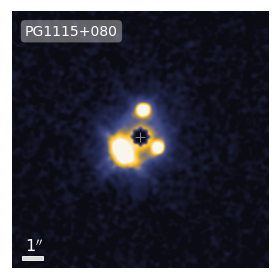

In [20]:
plt.imshow(np.log10(dij+1), extent=reconsrc.extent, vmax=np.log10(0.2*lvmax+1), **plt_kw)
# # labels and annotations
plot_scalebar(R=reconsrc.lensobject.mapr, length=1)
plot_labelbox(lens, position='top left')

# # force mask
# m = reconsrc.image_mask()
# m = reconsrc.mask
# msk = np.zeros(m.shape + (4,))
# msk[:, :, 3] = m
# plt.imshow(msk, origin='lower', extent=lo.extent)

# mask cross
c = reconsrc.lensobject.roi.buffer.center
c = (c - reconsrc.lensobject.center.xy) * reconsrc.lensobject.px2arcsec[0]
plt.plot(*c, marker='+', markersize=10, color='grey')

plt.axis('off')
plt.gcf().axes[0].get_xaxis().set_visible(False)
plt.gcf().axes[0].get_yaxis().set_visible(False)
plt.tight_layout()
plt.savefig("results/{}_data.pdf".format(lens), transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()


### Source plane

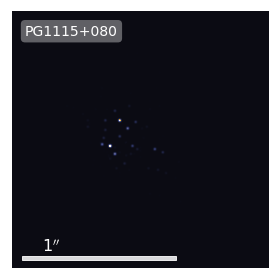

In [21]:
plt.imshow(srcplane, extent=reconsrc.src_extent, vmax=1*svmax,
           **plt_kw)

# labels and annotations
plot_scalebar(R=reconsrc.r_max, length=1)
plot_labelbox(lens, position='top left')

plt.axis('off')
plt.gcf().axes[0].get_xaxis().set_visible(False)
plt.gcf().axes[0].get_yaxis().set_visible(False)
plt.tight_layout()
plt.savefig("results/{}_{}_src.pdf".format(lens, lm.filename.replace('.state', '')), transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()


### Synthetic image

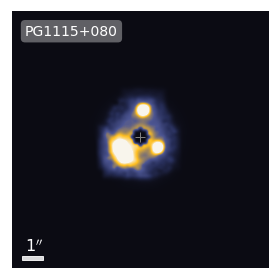

In [22]:
plt.imshow(np.log10(synth+1), extent=reconsrc.extent, vmax=np.log10(0.20*lvmax+1), **plt_kw)

# labels and annotations
plot_scalebar(R=reconsrc.lensobject.mapr, length=1)
plot_labelbox(lens, position='top left')

# # force mask
# m = reconsrc.image_mask()
# m = reconsrc.mask
# msk = np.zeros(m.shape + (4,))
# msk[:, :, 3] = m
# plt.imshow(msk, origin='lower', extent=lo.extent)

# mask cross
c = reconsrc.lensobject.roi.buffer.center
c = (c - reconsrc.lensobject.center.xy) * reconsrc.lensobject.px2arcsec[0]
plt.plot(*c, marker='+', markersize=10, color='grey')

plt.axis('off')
plt.gcf().axes[0].get_xaxis().set_visible(False)
plt.gcf().axes[0].get_yaxis().set_visible(False)
plt.tight_layout()
plt.savefig("results/{}_{}_best_synth.pdf".format(lens, lm.filename.replace('.state', '')), transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()


### Residual image

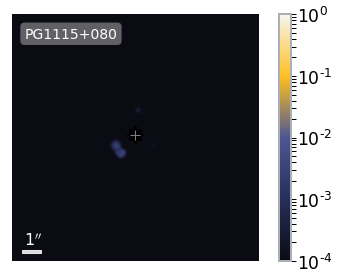

In [23]:
kwp = plt_kw.copy()
kwp.pop('cmap')
kwp.pop('vmin')
# rmap = resids

f1, f2 = 1, 1
rmap = (f1*dij/dij.max() - f2*synth/synth.max())**2
rmap[rmap == 0] = rmap[rmap != 0].min()
rmap[rmap < 1e-4] = 1e-4
# print dij.min(), dij.max(), synth.min(), synth.max()
# print rmap

plt.imshow(rmap, extent=reconsrc.extent, cmap='gravic',
           norm=mpl.colors.LogNorm(vmin=1e-4, vmax=1e0), **kwp)

# labels and annotations
plot_scalebar(R=reconsrc.lensobject.mapr, length=1)
plot_labelbox(lens, position='top left')
plt.colorbar()

# force mask
# m = reconsrc.image_mask()
m = reconsrc.mask
msk = np.zeros(m.shape + (4,))
msk[:, :, 3] = m
plt.imshow(msk, origin='lower', extent=lo.extent)

# mask cross
c = reconsrc.lensobject.roi.buffer.center
c = (c - reconsrc.lensobject.center.xy) * reconsrc.lensobject.px2arcsec[0]
plt.plot(*c, marker='+', markersize=10, color='grey')

plt.axis('off')
plt.gcf().axes[0].get_xaxis().set_visible(False)
plt.gcf().axes[0].get_yaxis().set_visible(False)
plt.tight_layout()
plt.savefig("results/{}_{}_resids.pdf".format(lens, lm.filename.replace('.state', '')), transparent=True, bbox_inches='tight')
plt.show()